# ANALYSE EXPLORATOIRE - DÉTECTION DE FRAUDE FINANCIÈRE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import psycopg2
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

### Chargement des données

In [3]:
conn=psycopg2.connect(
    dbname="frauddb",
    user="myuser",
    password="mypassword",
    host="postgres",
    port="5432"
)

In [33]:
df=pd.read_sql("select * from transactions_raw",conn)

### VUE D'ENSEMBLE DES DONNÉES

In [6]:
df.shape

(6362620, 11)

In [6]:
df.head(10)

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.00,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.00,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.00,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameorig        object 
 4   oldbalanceorg   float64
 5   newbalanceorig  float64
 6   namedest        object 
 7   oldbalancedest  float64
 8   newbalancedest  float64
 9   isfraud         int64  
 10  isflaggedfraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.describe()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


### QUALITÉ DES DONNÉES

In [9]:
missing = df.isnull().sum()
if missing.sum() > 0:
    missing_pct = 100 * missing / len(df)
    missing_df = pd.DataFrame({
        'Colonne': missing.index,
        'Manquantes': missing.values,
        'Pourcentage (%)': missing_pct.values
    })
    print("\n Valeurs manquantes:")
    print(missing_df[missing_df['Manquantes'] > 0].sort_values('Manquantes', ascending=False))
else:
    print("\n Aucune valeur manquante détectée!")


 Aucune valeur manquante détectée!


In [10]:
duplicates = df.duplicated().sum()
print(f"\n Doublons: {duplicates:,} lignes ({100*duplicates/len(df):.3f}%)")


 Doublons: 0 lignes (0.000%)


### Analyse de la variable cible ( isfraud) : analyse du déséquilibre des classes


Classe               Nombre          Pourcentage
-------------------------------------------------------
 Légitimes           6,354,407       99.871%
 Fraudes             8,213           0.129%

 Ratio de déséquilibre: 1:773
    → Pour 1 fraude, il y a ~773 transactions légitimes

 Conséquence: Un modèle naïf qui prédit toujours 'Non Fraude'
    aurait une accuracy de 99.87% (inutile!)


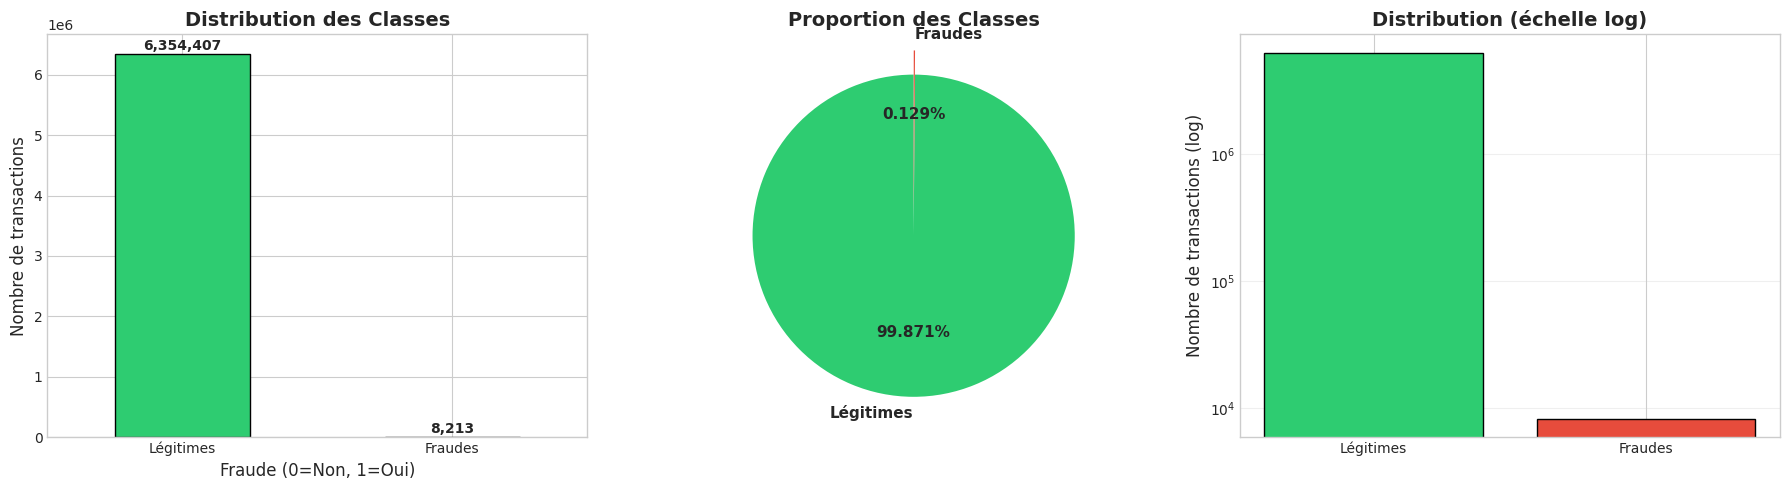

In [11]:
fraud_counts = df['isfraud'].value_counts()
fraud_pct = df['isfraud'].value_counts(normalize=True) * 100

print(f"\n{'Classe':<20} {'Nombre':<15} {'Pourcentage'}")
print("-"*55)
for classe, count in fraud_counts.items():
    label = " Fraudes" if classe == 1 else " Légitimes"
    print(f"{label:<20} {count:<15,} {fraud_pct[classe]:.3f}%")

fraud_ratio = fraud_counts[0] / fraud_counts[1]
print(f"\n Ratio de déséquilibre: 1:{int(fraud_ratio)}")
print(f"    → Pour 1 fraude, il y a ~{int(fraud_ratio)} transactions légitimes")
print(f"\n Conséquence: Un modèle naïf qui prédit toujours 'Non Fraude'")
print(f"    aurait une accuracy de {fraud_pct[0]:.2f}% (inutile!)")


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


fraud_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fraude (0=Non, 1=Oui)', fontsize=12)
axes[0].set_ylabel('Nombre de transactions', fontsize=12)
axes[0].set_xticklabels(['Légitimes', 'Fraudes'], rotation=0)
for i, v in enumerate(fraud_counts):
    axes[0].text(i, v + len(df)*0.01, f'{v:,}', ha='center', fontweight='bold')


colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.15)
axes[1].pie(fraud_counts, labels=['Légitimes', 'Fraudes'], autopct='%1.3f%%',
            startangle=90, colors=colors, explode=explode, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')


axes[2].bar(['Légitimes', 'Fraudes'], fraud_counts, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[2].set_yscale('log')
axes[2].set_title('Distribution (échelle log)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Nombre de transactions (log)', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Analyse du type de transaction 


 Distribution des types de transactions:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

 Fraudes par type de transaction:
isfraud         0     1      All  Taux_Fraude_%
type                                           
CASH_IN   1399284     0  1399284           0.00
CASH_OUT  2233384  4116  2237500           0.18
DEBIT       41432     0    41432           0.00
PAYMENT   2151495     0  2151495           0.00
TRANSFER   528812  4097   532909           0.77
All       6354407  8213  6362620           0.13


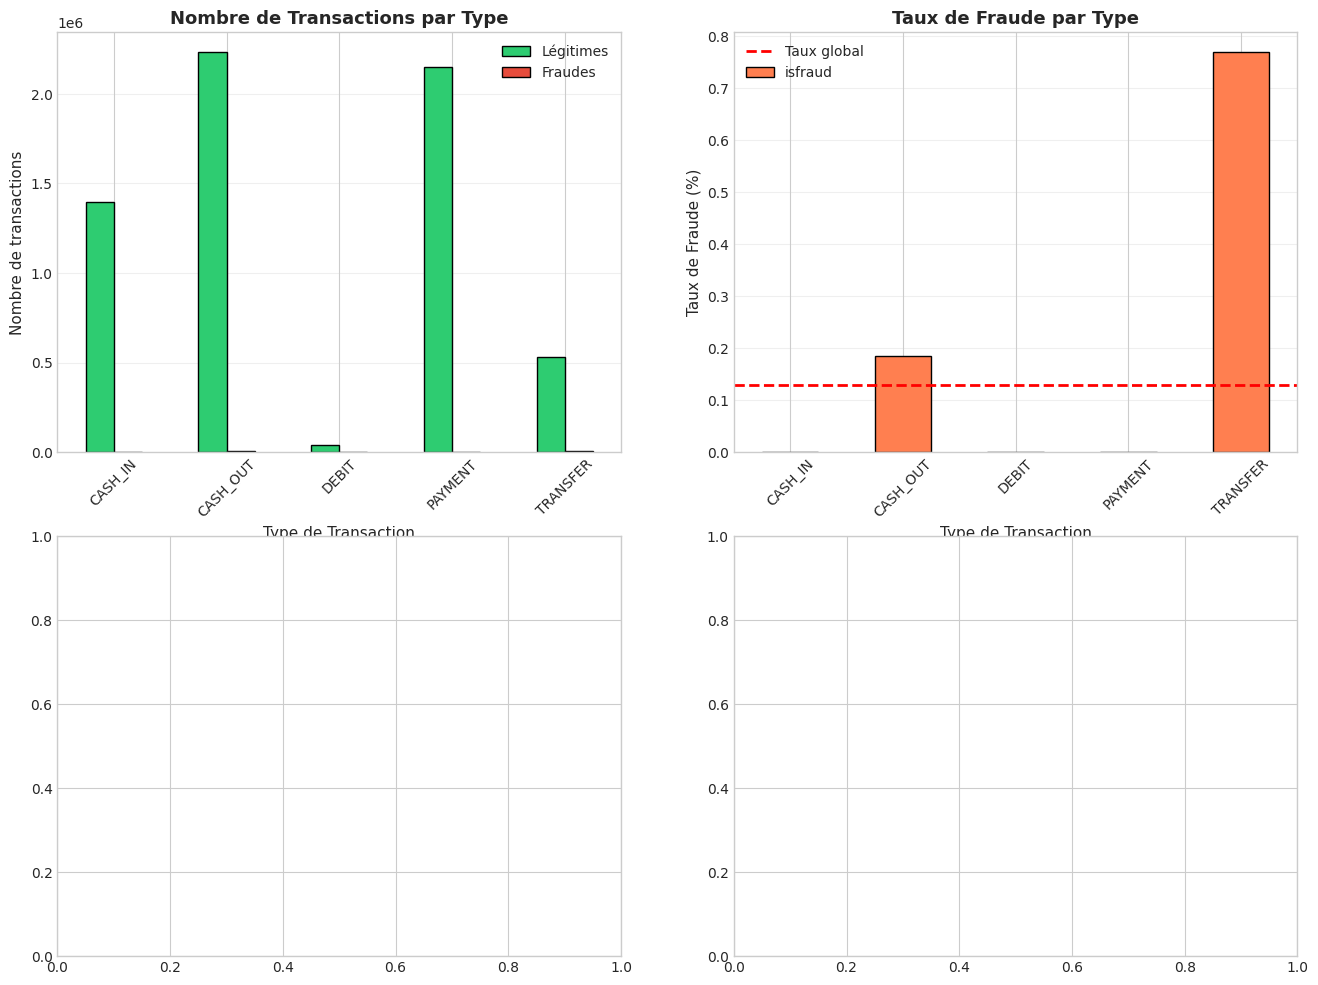

In [12]:
print("\n Distribution des types de transactions:")
type_counts = df['type'].value_counts()
print(type_counts)

# Fraude par type
print("\n Fraudes par type de transaction:")
fraud_by_type = pd.crosstab(df['type'], df['isfraud'], margins=True)
fraud_by_type['Taux_Fraude_%'] = (fraud_by_type[1] / fraud_by_type['All']) * 100
print(fraud_by_type)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Count plot global
type_fraud = df.groupby(['type', 'isfraud']).size().unstack(fill_value=0)
type_fraud.plot(kind='bar', ax=axes[0,0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0,0].set_title('Nombre de Transactions par Type', fontsize=13, fontweight='bold')
axes[0,0].set_xlabel('Type de Transaction', fontsize=11)
axes[0,0].set_ylabel('Nombre de transactions', fontsize=11)
axes[0,0].legend(['Légitimes', 'Fraudes'], loc='upper right')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Taux de fraude par type
fraud_rate_by_type = df.groupby('type')['isfraud'].mean() * 100
fraud_rate_by_type.plot(kind='bar', ax=axes[0,1], color='coral', edgecolor='black')
axes[0,1].set_title('Taux de Fraude par Type', fontsize=13, fontweight='bold')
axes[0,1].set_xlabel('Type de Transaction', fontsize=11)
axes[0,1].set_ylabel('Taux de Fraude (%)', fontsize=11)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=fraud_pct[1], color='r', linestyle='--', linewidth=2, label='Taux global')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

### Analyse du Montants

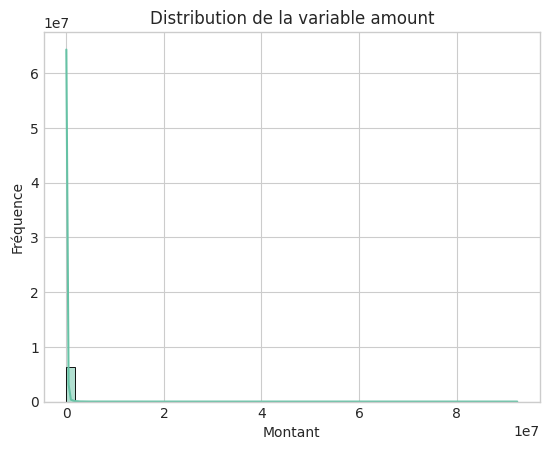

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Distribution de la variable amount")
plt.xlabel("Montant")
plt.ylabel("Fréquence")
plt.show()


- La distribution de la variable amount n’est pas normale. Par conséquent, le test de Student n’est pas approprié. Nous utiliserons à la place le test de Mann-Whitney U, qui est un test non paramétrique ne nécessitant pas l’hypothèse de normalité.


 Statistiques du montant par classe:
             count       mean        std  min       25%       50%        75%  \
isfraud                                                                        
0       6354407.00  178197.04  596236.98 0.01  13368.40  74684.72  208364.76   
1          8213.00 1467967.30 2404252.95 0.00 127091.33 441423.44 1517771.48   

                max  
isfraud              
0       92445516.64  
1       10000000.00  

 Test de Mann-Whitney U (différence de distribution):
   Statistique: 1.10e+10
   p-value: 0.00e+00
   → Les distributions sont SIGNIFICATIVEMENT DIFFÉRENTES


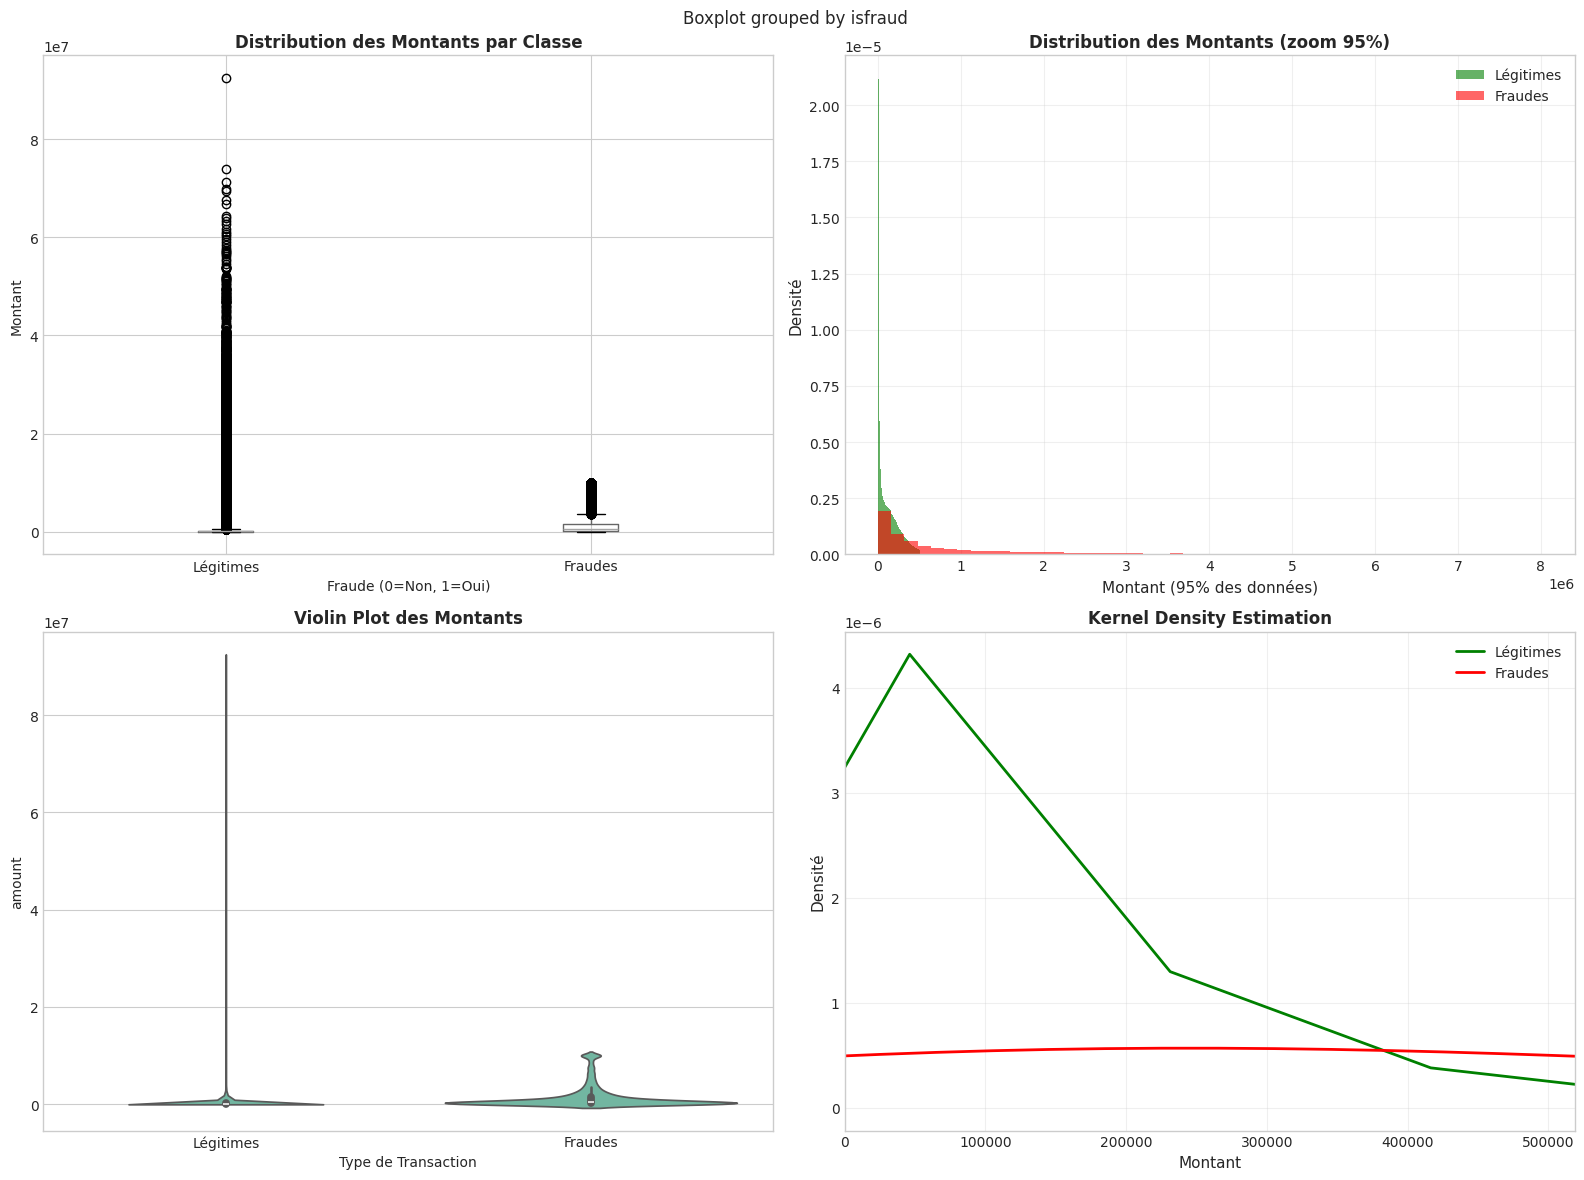

In [14]:
print("\n Statistiques du montant par classe:")
amount_stats = df.groupby('isfraud')['amount'].describe()
print(amount_stats)

# Test statistique
legit_amounts = df[df['isfraud']==0]['amount']
fraud_amounts = df[df['isfraud']==1]['amount']
statistic, pvalue = stats.mannwhitneyu(legit_amounts, fraud_amounts)
print(f"\n Test de Mann-Whitney U (différence de distribution):")
print(f"   Statistique: {statistic:.2e}")
print(f"   p-value: {pvalue:.2e}")
print(f"   → Les distributions sont {'SIGNIFICATIVEMENT DIFFÉRENTES' if pvalue < 0.05 else 'SIMILAIRES'}")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Boxplot
df.boxplot(column='amount', by='isfraud', ax=axes[0,0])
axes[0,0].set_title('Distribution des Montants par Classe', fontweight='bold')
axes[0,0].set_xlabel('Fraude (0=Non, 1=Oui)')
axes[0,0].set_ylabel('Montant')
plt.sca(axes[0,0])
plt.xticks([1, 2], ['Légitimes', 'Fraudes'])

# 2. Histogrammes superposés (avec limite pour visibilité)
axes[0,1].hist(legit_amounts[legit_amounts <= legit_amounts.quantile(0.95)], 
               bins=50, alpha=0.6, label='Légitimes', color='green', density=True)
axes[0,1].hist(fraud_amounts[fraud_amounts <= fraud_amounts.quantile(0.95)], 
               bins=50, alpha=0.6, label='Fraudes', color='red', density=True)
axes[0,1].set_xlabel('Montant (95% des données)', fontsize=11)
axes[0,1].set_ylabel('Densité', fontsize=11)
axes[0,1].set_title('Distribution des Montants (zoom 95%)', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Violin plot
sns.violinplot(data=df, x='isfraud', y='amount', ax=axes[1,0])
axes[1,0].set_title('Violin Plot des Montants', fontweight='bold')
axes[1,0].set_xticklabels(['Légitimes', 'Fraudes'])
axes[1,0].set_xlabel('Type de Transaction')

# 4. KDE (distribution lissée)
legit_amounts.plot.kde(ax=axes[1,1], label='Légitimes', color='green', linewidth=2)
fraud_amounts.plot.kde(ax=axes[1,1], label='Fraudes', color='red', linewidth=2)
axes[1,1].set_xlabel('Montant', fontsize=11)
axes[1,1].set_ylabel('Densité', fontsize=11)
axes[1,1].set_title('Kernel Density Estimation', fontweight='bold')
axes[1,1].legend()
axes[1,1].set_xlim(0, df['amount'].quantile(0.95))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



 Taux de fraude par tranche de montant:
                           Nb_Fraudes  Total_Trans  Taux_Fraude  Taux_Fraude_%
amount_bin                                                                    
(-0.001, 4501.3]                  148       636263         0.00           0.02
(4501.3, 9866.158]                128       636261         0.00           0.02
(9866.158, 18092.028]             148       636262         0.00           0.02
(18092.028, 36371.35]             365       636262         0.00           0.06
(36371.35, 74871.94]              617       636262         0.00           0.10
(74871.94, 122563.784]            592       636262         0.00           0.09
(122563.784, 176801.919]          581       636262         0.00           0.09
(176801.919, 246611.22]           503       636262         0.00           0.08
(246611.22, 365423.309]           719       636262         0.00           0.11
(365423.309, 92445516.64]        4412       636262         0.01           0.69


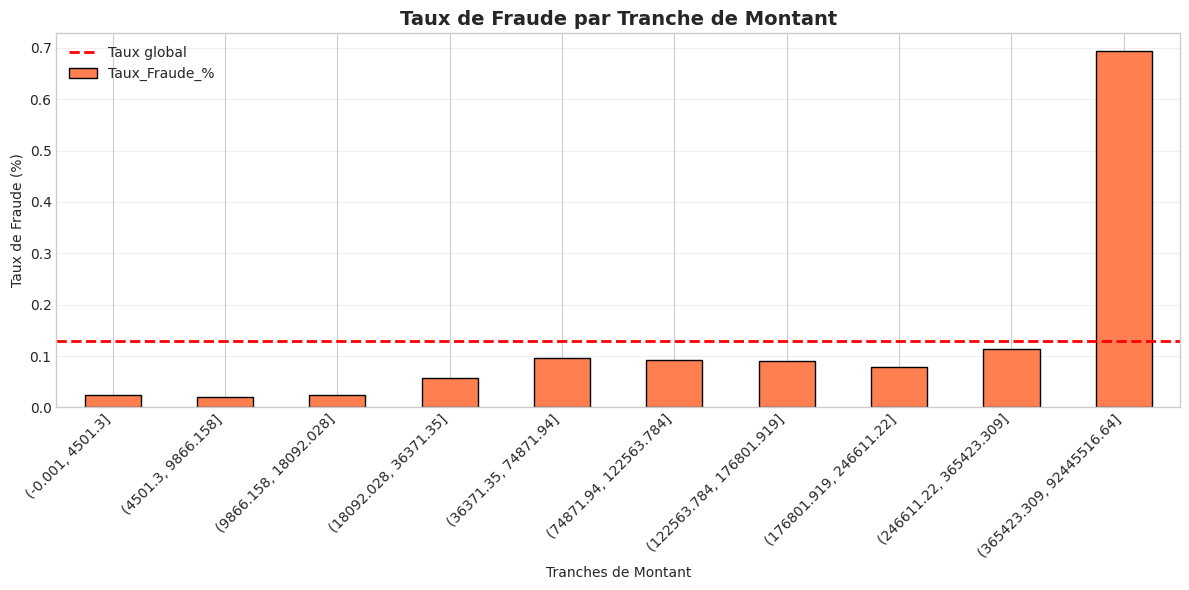

In [15]:
print("\n Taux de fraude par tranche de montant:")
df['amount_bin'] = pd.qcut(df['amount'], q=10, duplicates='drop')
fraud_by_amount = df.groupby('amount_bin', observed=True).agg({
    'isfraud': ['sum', 'count', 'mean']
})
fraud_by_amount.columns = ['Nb_Fraudes', 'Total_Trans', 'Taux_Fraude']
fraud_by_amount['Taux_Fraude_%'] = fraud_by_amount['Taux_Fraude'] * 100
print(fraud_by_amount)

# Visualisation
plt.figure(figsize=(12, 6))
fraud_by_amount['Taux_Fraude_%'].plot(kind='bar', color='coral', edgecolor='black')
plt.title('Taux de Fraude par Tranche de Montant', fontweight='bold', fontsize=14)
plt.xlabel('Tranches de Montant')
plt.ylabel('Taux de Fraude (%)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=fraud_pct[1], color='r', linestyle='--', linewidth=2, label='Taux global')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

df.drop('amount_bin', axis=1, inplace=True)


 Dataset: 6,362,620 transactions
 Taux de fraude global: 0.129%

  ÉTAPE 1: EXTRACTION DE L'HEURE

 Variable 'hour' créée (valeurs: 0 à 23)

 Distribution des heures:
hour
0     71587
1     27111
2      9018
3      2007
4      1241
5      1641
6      3420
7      8988
8     26915
9    283518
Name: count, dtype: int64

  ÉTAPE 2: DÉFINITION DES PÉRIODES

 Périodes créées:
period
Après-midi (12h-18h)    2689784
Soir (18h-24h)          2365669
Matin (6h-12h)          1194562
Nuit (0h-6h)             112605
Name: count, dtype: int64

 ÉTAPE 3: COMPARAISON NUIT VS JOUR

 STATISTIQUES NUIT VS JOUR:
               Total_Trans  Nb_Fraudes  Taux_Fraude  Taux_Fraude_%
time_category                                                     
Jour (6h-24h)      6250015        6217         0.00           0.10
Nuit (0h-6h)        112605        1996         0.02           1.77

 INSIGHTS CLÉS

 NUIT (0h-6h):
   • 112,605 transactions (1.8% du total)
   • 1996 fraudes
   • Taux de fraude: 1.7700%

 JOUR (6h-

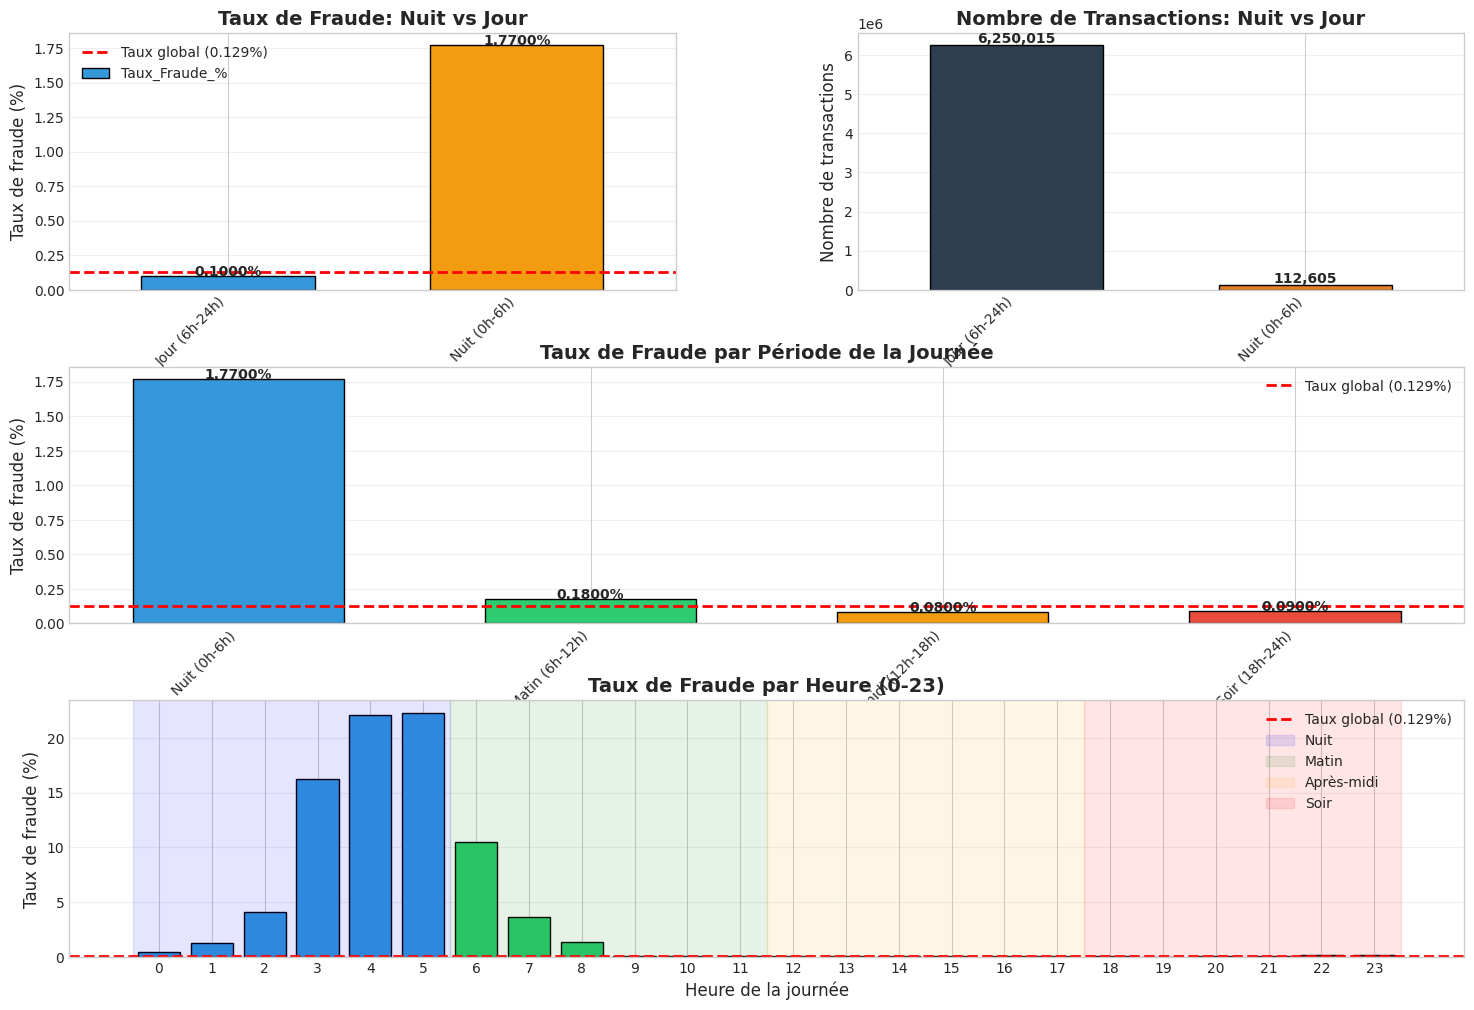


  ÉTAPE 7: TEST STATISTIQUE

 Table de contingence:
isfraud         0     1
is_night               
0         6243798  6217
1          110609  1996

 Test du Chi-2 d'indépendance:
   Chi-2 statistic: 24005.1775
   p-value: 0.0000e+00
   Degrés de liberté: 1

 CONCLUSION: Le moment de la journée (nuit vs jour) est
   SIGNIFICATIVEMENT associé au risque de fraude (p < 0.05)


In [16]:
print(f"\n Dataset: {df.shape[0]:,} transactions")
print(f" Taux de fraude global: {df['isfraud'].mean()*100:.3f}%")

# ============================================================================
# 1. CRÉATION DES VARIABLES TEMPORELLES
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 1: EXTRACTION DE L'HEURE")
print("="*70)

# Extraire l'heure de la journée (0-23)
df['hour'] = df['step'] % 24

print(f"\n Variable 'hour' créée (valeurs: {df['hour'].min()} à {df['hour'].max()})")
print(f"\n Distribution des heures:")
print(df['hour'].value_counts().sort_index().head(10))

# ============================================================================
# 2. DÉFINITION DES PÉRIODES
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 2: DÉFINITION DES PÉRIODES")
print("="*70)

# Définir les périodes (vous pouvez ajuster ces seuils)
df['period'] = 'Unknown'
df.loc[(df['hour'] >= 0) & (df['hour'] < 6), 'period'] = 'Nuit (0h-6h)'
df.loc[(df['hour'] >= 6) & (df['hour'] < 12), 'period'] = 'Matin (6h-12h)'
df.loc[(df['hour'] >= 12) & (df['hour'] < 18), 'period'] = 'Après-midi (12h-18h)'
df.loc[(df['hour'] >= 18) & (df['hour'] < 24), 'period'] = 'Soir (18h-24h)'

# Aussi créer une version simplifiée: Nuit (0h-6h) vs Jour (6h-24h)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] < 6)).astype(int)
df['time_category'] = df['is_night'].map({1: 'Nuit (0h-6h)', 0: 'Jour (6h-24h)'})

print("\n Périodes créées:")
print(df['period'].value_counts())

# ============================================================================
# 3. ANALYSE GLOBALE: NUIT VS JOUR
# ============================================================================
print("\n" + "="*70)
print(" ÉTAPE 3: COMPARAISON NUIT VS JOUR")
print("="*70)

# Calculer les statistiques pour Nuit vs Jour
night_day_stats = df.groupby('time_category').agg({
    'isfraud': ['count', 'sum', 'mean']
}).round(4)

night_day_stats.columns = ['Total_Trans', 'Nb_Fraudes', 'Taux_Fraude']
night_day_stats['Taux_Fraude_%'] = night_day_stats['Taux_Fraude'] * 100

print("\n STATISTIQUES NUIT VS JOUR:")
print(night_day_stats)

# Calculer le ratio
jour_stats = night_day_stats.loc['Jour (6h-24h)']
nuit_stats = night_day_stats.loc['Nuit (0h-6h)']

ratio = nuit_stats['Taux_Fraude_%'] / jour_stats['Taux_Fraude_%']

print("\n" + "="*50)
print(" INSIGHTS CLÉS")
print("="*50)
print(f"\n NUIT (0h-6h):")
print(f"   • {nuit_stats['Total_Trans']:,.0f} transactions ({nuit_stats['Total_Trans']/len(df)*100:.1f}% du total)")
print(f"   • {nuit_stats['Nb_Fraudes']:.0f} fraudes")
print(f"   • Taux de fraude: {nuit_stats['Taux_Fraude_%']:.4f}%")

print(f"\n JOUR (6h-24h):")
print(f"   • {jour_stats['Total_Trans']:,.0f} transactions ({jour_stats['Total_Trans']/len(df)*100:.1f}% du total)")
print(f"   • {jour_stats['Nb_Fraudes']:.0f} fraudes")
print(f"   • Taux de fraude: {jour_stats['Taux_Fraude_%']:.4f}%")

print(f"\n COMPARAISON:")
if ratio > 1:
    print(f"   → Le taux de fraude la NUIT est {ratio:.2f}x plus élevé que le JOUR")
elif ratio < 1:
    print(f"   → Le taux de fraude le JOUR est {1/ratio:.2f}x plus élevé que la NUIT")
else:
    print(f"   → Les taux de fraude sont identiques")

# ============================================================================
# 4. ANALYSE DÉTAILLÉE PAR PÉRIODE
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 4: ANALYSE PAR PÉRIODE DÉTAILLÉE")
print("="*70)

period_stats = df.groupby('period').agg({
    'isfraud': ['count', 'sum', 'mean']
}).round(4)

period_stats.columns = ['Total_Trans', 'Nb_Fraudes', 'Taux_Fraude']
period_stats['Taux_Fraude_%'] = period_stats['Taux_Fraude'] * 100

# Trier par ordre chronologique
period_order = ['Nuit (0h-6h)', 'Matin (6h-12h)', 'Après-midi (12h-18h)', 'Soir (18h-24h)']
period_stats = period_stats.reindex(period_order)

print("\n STATISTIQUES PAR PÉRIODE:")
print(period_stats)

# ============================================================================
# 5. ANALYSE HEURE PAR HEURE
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 5: ANALYSE HEURE PAR HEURE")
print("="*70)

hour_stats = df.groupby('hour').agg({
    'isfraud': ['count', 'sum', 'mean']
}).round(4)

hour_stats.columns = ['Total_Trans', 'Nb_Fraudes', 'Taux_Fraude']
hour_stats['Taux_Fraude_%'] = hour_stats['Taux_Fraude'] * 100

print("\n Top 5 heures avec le PLUS de fraudes:")
print(hour_stats.nlargest(5, 'Taux_Fraude_%'))

print("\n Top 5 heures avec le MOINS de fraudes:")
print(hour_stats.nsmallest(5, 'Taux_Fraude_%'))

# ============================================================================
# 6. VISUALISATIONS
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 6: VISUALISATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ─────────────────────────────────────────────────────────────────────────
# Graphique 1: Comparaison Nuit vs Jour (Barplot)
# ─────────────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#3498db', '#f39c12']
night_day_stats['Taux_Fraude_%'].plot(kind='bar', ax=ax1, color=colors, edgecolor='black', width=0.6)
ax1.set_title('Taux de Fraude: Nuit vs Jour', fontweight='bold', fontsize=14)
ax1.set_xlabel('Période', fontsize=12)
ax1.set_ylabel('Taux de fraude (%)', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(night_day_stats['Taux_Fraude_%']):
    ax1.text(i, v + 0.001, f'{v:.4f}%', ha='center', fontweight='bold')

# Ajouter la ligne de référence (taux global)
taux_global = df['isfraud'].mean() * 100
ax1.axhline(y=taux_global, color='red', linestyle='--', linewidth=2, label=f'Taux global ({taux_global:.3f}%)')
ax1.legend()

# ─────────────────────────────────────────────────────────────────────────
# Graphique 2: Nombre de transactions Nuit vs Jour
# ─────────────────────────────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
night_day_stats['Total_Trans'].plot(kind='bar', ax=ax2, color=['#2c3e50', '#e67e22'], edgecolor='black', width=0.6)
ax2.set_title('Nombre de Transactions: Nuit vs Jour', fontweight='bold', fontsize=14)
ax2.set_xlabel('Période', fontsize=12)
ax2.set_ylabel('Nombre de transactions', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for i, v in enumerate(night_day_stats['Total_Trans']):
    ax2.text(i, v + len(df)*0.01, f'{int(v):,}', ha='center', fontweight='bold')

# ─────────────────────────────────────────────────────────────────────────
# Graphique 3: Taux de fraude par période (4 périodes)
# ─────────────────────────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, :])
period_colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
x_pos = np.arange(len(period_stats))
bars = ax3.bar(x_pos, period_stats['Taux_Fraude_%'], color=period_colors, edgecolor='black', width=0.6)
ax3.set_title('Taux de Fraude par Période de la Journée', fontweight='bold', fontsize=14)
ax3.set_xlabel('Période', fontsize=12)
ax3.set_ylabel('Taux de fraude (%)', fontsize=12)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(period_stats.index, rotation=45, ha='right')
ax3.axhline(y=taux_global, color='red', linestyle='--', linewidth=2, label=f'Taux global ({taux_global:.3f}%)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for i, (idx, row) in enumerate(period_stats.iterrows()):
    ax3.text(i, row['Taux_Fraude_%'] + 0.001, f"{row['Taux_Fraude_%']:.4f}%", 
             ha='center', fontweight='bold', fontsize=10)

# ─────────────────────────────────────────────────────────────────────────
# Graphique 4: Taux de fraude heure par heure
# ─────────────────────────────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[2, :])

# Créer un gradient de couleurs selon les périodes
colors_hour = []
for h in hour_stats.index:
    if 0 <= h < 6:
        colors_hour.append('#3498db')  # Nuit
    elif 6 <= h < 12:
        colors_hour.append('#2ecc71')  # Matin
    elif 12 <= h < 18:
        colors_hour.append('#f39c12')  # Après-midi
    else:
        colors_hour.append('#e74c3c')  # Soir

ax4.bar(hour_stats.index, hour_stats['Taux_Fraude_%'], color=colors_hour, edgecolor='black', width=0.8)
ax4.set_title('Taux de Fraude par Heure (0-23)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Heure de la journée', fontsize=12)
ax4.set_ylabel('Taux de fraude (%)', fontsize=12)
ax4.set_xticks(range(24))
ax4.axhline(y=taux_global, color='red', linestyle='--', linewidth=2, label=f'Taux global ({taux_global:.3f}%)')

# Ajouter des zones d'ombre pour les périodes
ax4.axvspan(-0.5, 5.5, alpha=0.1, color='blue', label='Nuit')
ax4.axvspan(5.5, 11.5, alpha=0.1, color='green', label='Matin')
ax4.axvspan(11.5, 17.5, alpha=0.1, color='orange', label='Après-midi')
ax4.axvspan(17.5, 23.5, alpha=0.1, color='red', label='Soir')

ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. TEST STATISTIQUE
# ============================================================================
print("\n" + "="*70)
print("  ÉTAPE 7: TEST STATISTIQUE")
print("="*70)

from scipy.stats import chi2_contingency

# Créer une table de contingence
contingency_table = pd.crosstab(df['is_night'], df['isfraud'])
print("\n Table de contingence:")
print(contingency_table)

# Test du Chi-2
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n Test du Chi-2 d'indépendance:")
print(f"   Chi-2 statistic: {chi2:.4f}")
print(f"   p-value: {p_value:.4e}")
print(f"   Degrés de liberté: {dof}")

if p_value < 0.05:
    print(f"\n CONCLUSION: Le moment de la journée (nuit vs jour) est")
    print(f"   SIGNIFICATIVEMENT associé au risque de fraude (p < 0.05)")
else:
    print(f"\n CONCLUSION: Pas de différence significative entre")
    print(f"   nuit et jour (p >= 0.05)")

### Analyse des soldes


 Statistiques des soldes par classe:

oldbalanceorg:
              mean       50%        std         max
isfraud                                            
0        832828.71  14069.00 2887144.03 43818855.30
1       1649667.61 438983.45 3547719.44 59585040.37

newbalanceorig:
             mean  50%        std         max
isfraud                                      
0       855970.23 0.00 2924986.96 43686616.33
1       192392.63 0.00 1965666.46 49585040.37

oldbalancedest:
              mean       50%        std          max
isfraud                                             
0       1101420.87 133311.80 3399201.79 356015889.35
1        544249.62      0.00 3336420.95 236230516.82

newbalancedest:
              mean       50%        std          max
isfraud                                             
0       1224925.68 214881.70 3673815.71 356179278.92
1       1279707.62   4676.42 3908816.53 236726494.66


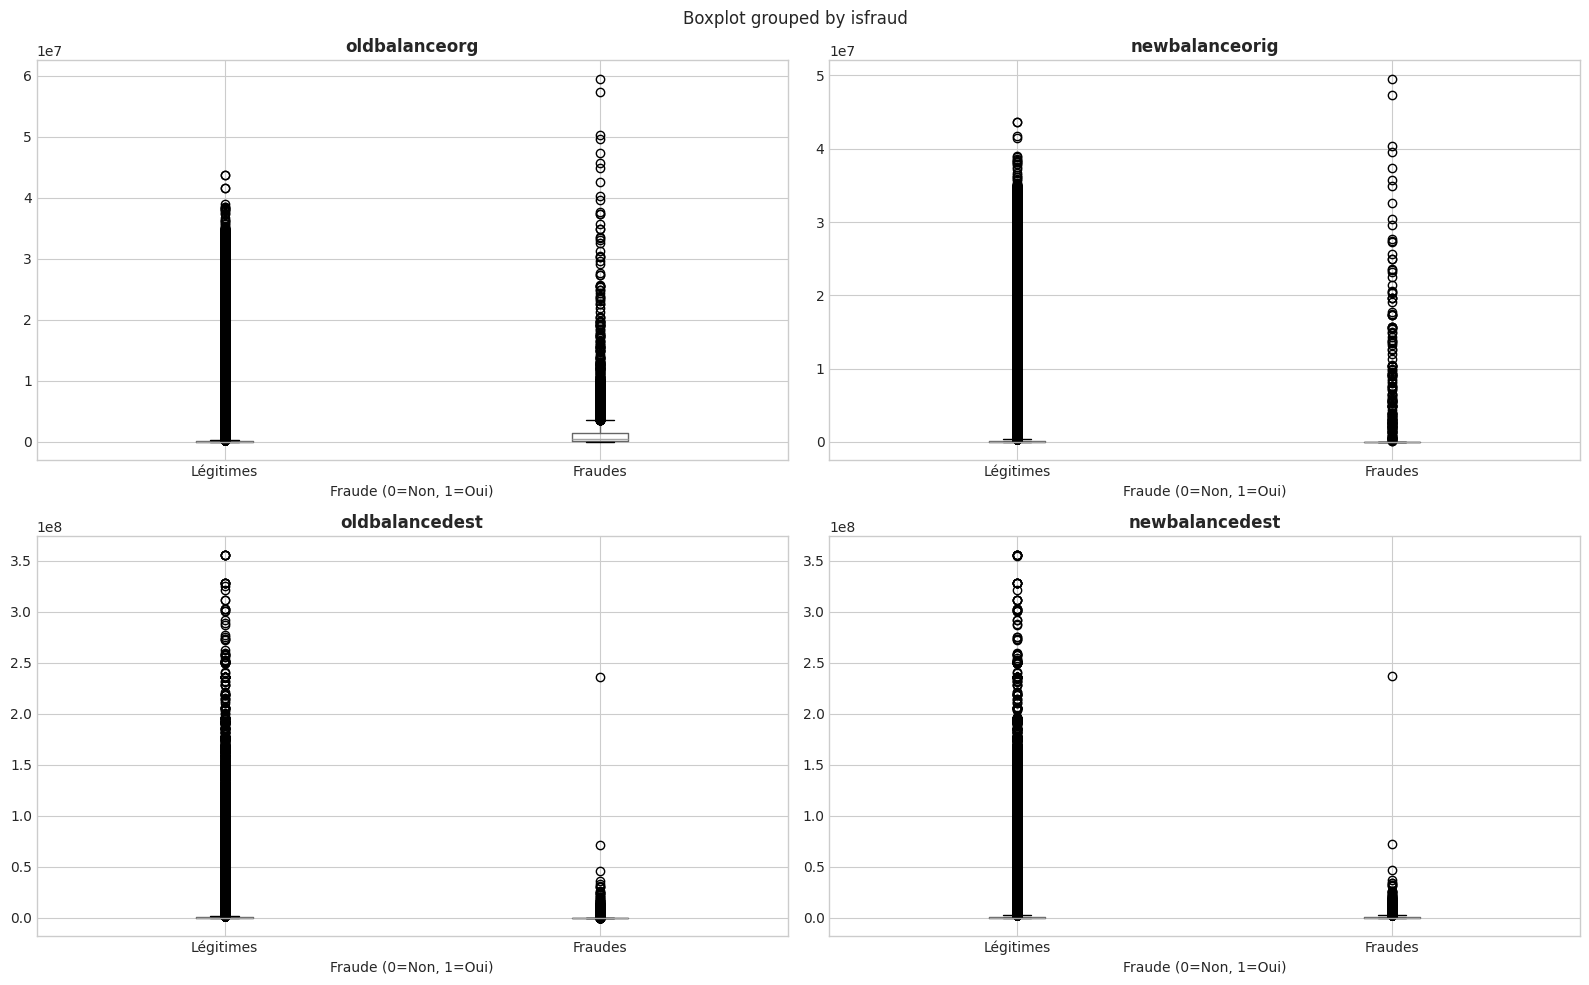

In [17]:
balance_cols = ['oldbalanceorg', 'newbalanceorig', 'oldbalancedest', 'newbalancedest']

print("\n Statistiques des soldes par classe:")
for col in balance_cols:
    print(f"\n{col}:")
    print(df.groupby('isfraud')[col].describe()[['mean', '50%', 'std', 'max']])

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, col in enumerate(balance_cols):
    ax = axes[idx // 2, idx % 2]
    df.boxplot(column=col, by='isfraud', ax=ax)
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_xlabel('Fraude (0=Non, 1=Oui)')
    plt.sca(ax)
    plt.xticks([1, 2], ['Légitimes', 'Fraudes'])

plt.tight_layout()
plt.show()

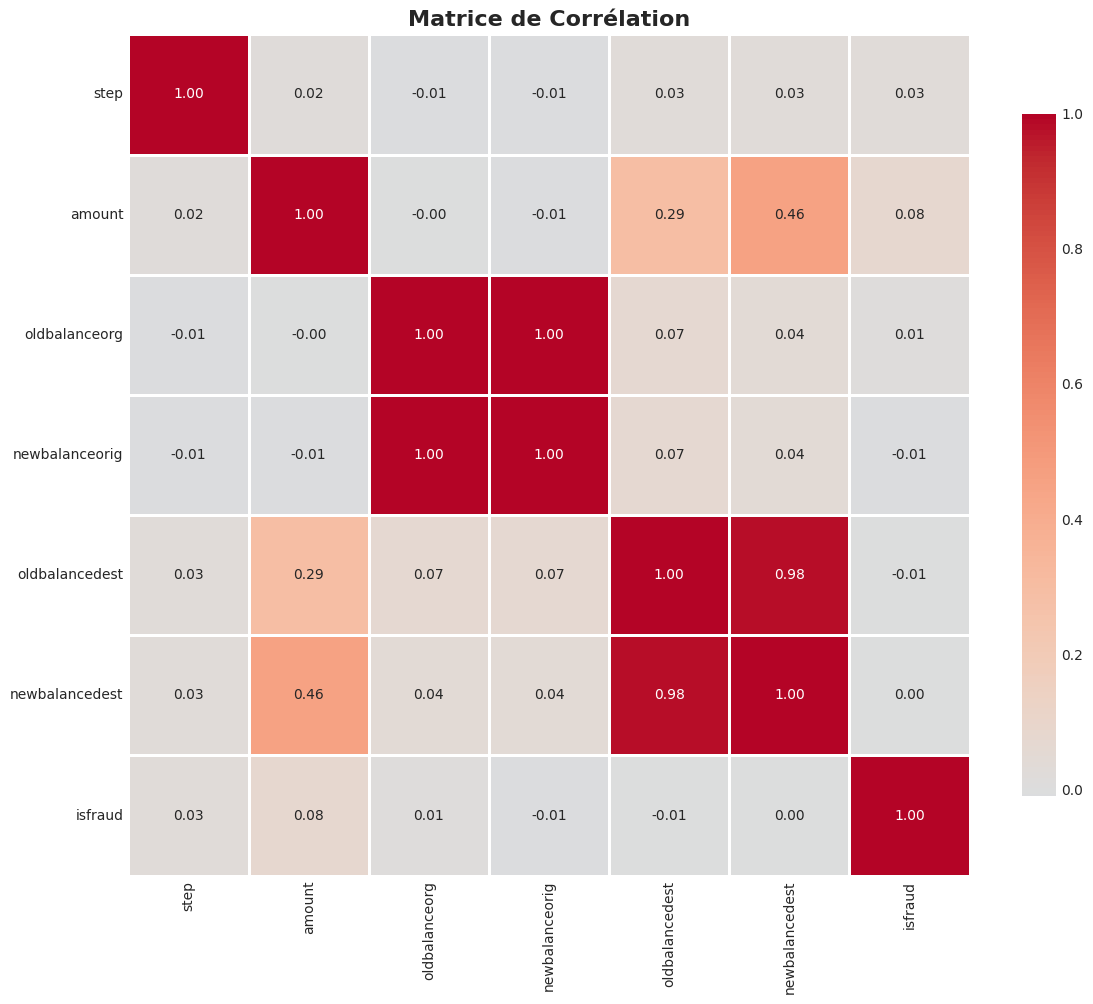


 Top corrélations avec isFraud:
amount           0.08
step             0.03
oldbalanceorg    0.01
newbalanceorig   0.01
oldbalancedest   0.01
newbalancedest   0.00
Name: isfraud, dtype: float64


In [18]:
numeric_cols = ['step', 'amount', 'oldbalanceorg', 'newbalanceorig', 
                'oldbalancedest', 'newbalancedest', 'isfraud']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

print("\n Top corrélations avec isFraud:")
fraud_corr = corr_matrix['isfraud'].abs().sort_values(ascending=False)
print(fraud_corr[1:])

## Entrainement du modele 

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

In [34]:
df = df.drop(['nameorig', 'namedest'], axis=1)
df['type'] = LabelEncoder().fit_transform(df['type'])
X = df.drop(['isfraud', 'isflaggedfraud'], axis=1)
y = df['isfraud']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("Fraude_Detection")

<Experiment: artifact_location='/mlflow/mlruns/1', creation_time=1764283423887, experiment_id='1', last_update_time=1764283423887, lifecycle_stage='active', name='Fraude_Detection', tags={}>

In [14]:
def train_and_log_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)

        
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} - Accuracy: {acc:.4f}, F1: {f1:.4f} ,recall: {rec:.4f}")

In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

In [16]:
for name, model in models.items():
    train_and_log_model(model, name)

Logistic Regression - Accuracy: 0.9992, F1: 0.5695 ,recall: 0.4148
Random Forest - Accuracy: 0.9997, F1: 0.8707 ,recall: 0.7845
XGBoost - Accuracy: 0.9998, F1: 0.8995 ,recall: 0.8515


#### Les interpretations :
- la régression logistique détecte trop peu de fraudes (recall faible) , Trop de faux négatifs = beaucoup de fraudes non détectées(ce n’est pas acceptable dans un système réel)
- pour *random forest* , 
  le modele détecte beaucoup plus de fraudes (recall = 0.78) ,garde une precision extrêmement haute
- pour *XGBoost* , Il trouve plus de fraudes (recall augmente), Il gère bien les données très déséquilibrées, Il capture mieux les patterns complexes que Random Forest et Logistic

### Appliquée des améliorations pour gérer le désequilibre des classes

In [17]:
mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("Fraude_Detection2")

2025/11/30 22:28:36 INFO mlflow.tracking.fluent: Experiment with name 'Fraude_Detection2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mlflow/mlruns/2', creation_time=1764541716186, experiment_id='2', last_update_time=1764541716186, lifecycle_stage='active', name='Fraude_Detection2', tags={}>

In [18]:
def train_and_log_model(model, model_name):
    with mlflow.start_run(run_name=model_name):
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)

        
        mlflow.sklearn.log_model(model, model_name)

        print(f"{model_name} - Accuracy: {acc:.4f}, F1: {f1:.4f} ,recall: {rec:.4f}")

In [19]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss",scale_pos_weight=6354407/8213)
}

In [20]:
for name, model in models.items():
    train_and_log_model(model, name)

Logistic Regression - Accuracy: 0.9644, F1: 0.0593 ,recall: 0.8681
Random Forest - Accuracy: 0.9997, F1: 0.8656 ,recall: 0.7723
XGBoost - Accuracy: 0.9985, F1: 0.6315 ,recall: 0.9825


#### Les interpretations 
##### pour regression logistique 
- Avec class_weight='balanced' le modele donne beaucoup plus d’importance à la classe fraude (1)
- devient très agressive dans la détection de fraude
- prédit "fraude" même quand la probabilité est relativement faible
- le modele  prédit trop de fraudes, donc elle génère énormément de faux positifs.
pour cela la précision  est devenue très faible (0.0306) et recall augemente (0.8681006493506493)
##### donc la regression logistique ne marche pas avec ce type de probleme parce que les patterns de fraud ne sont pas lineaire et aussi les clases sont fortement déséquilibré

### XGBOOST

In [22]:
model=XGBClassifier(use_label_encoder=False, eval_metric="logloss")
train_and_log_model(model,"XGBoost")

XGBoost - Accuracy: 0.9998, F1: 0.8995 ,recall: 0.8515


In [23]:
from sklearn.metrics import average_precision_score

y_proba = model.predict_proba(X_test)[:, 1]
prauc = average_precision_score(y_test, y_proba)

print("PR-AUC :", prauc)

PR-AUC : 0.9630449307110945


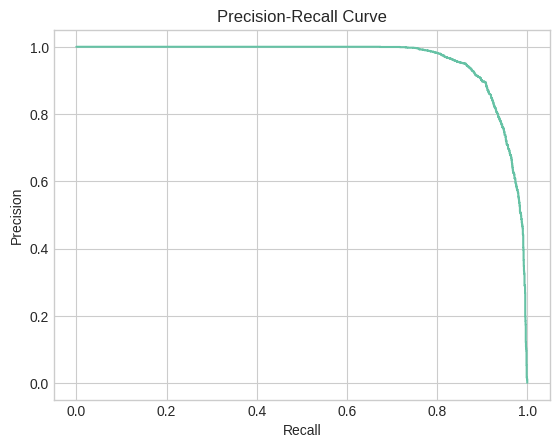

In [24]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

- Tant que recall < 0.85–0.90, la précision reste très élevée.
- modèle continue d’être fiable en augmentant le recall.

### Logistic Regression

In [25]:
model=LogisticRegression(max_iter=1000)
train_and_log_model(model,"Logistic Regression")

Logistic Regression - Accuracy: 0.9992, F1: 0.5695 ,recall: 0.4148


In [26]:
from sklearn.metrics import average_precision_score

y_proba = model.predict_proba(X_test)[:, 1]
prauc = average_precision_score(y_test, y_proba)

print("PR-AUC :", prauc)


PR-AUC : 0.5690402696707576


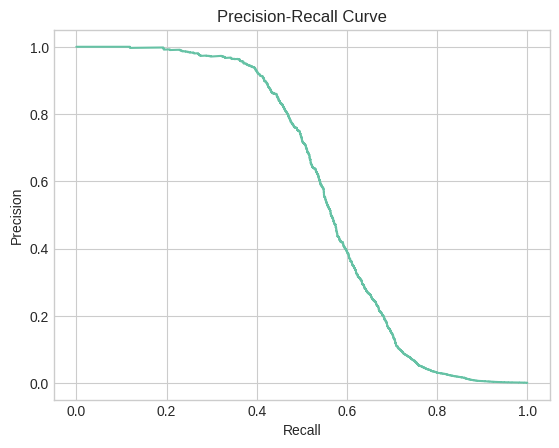

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

- Mauvaise précision dès qu’on augmente le recall
- Au début precision ~1.0 (normal) mais elle chute très rapidement
  - à recall 0.4 → precision déjà < 0.8
  - à recall 0.6 → precision < 0.4
  - à recall 0.8 → precision proche de 0.1
  - à recall 1.0 → precision → 0

modèle faible sur données déséquilibrées.

XGBoost est clairement le meilleur modèle

#### Calculer PR-AUC sur data train 

In [28]:
model=XGBClassifier(use_label_encoder=False, eval_metric="logloss")
train_and_log_model(model,"XGBoost")
from sklearn.metrics import average_precision_score

y_proba = model.predict_proba(X_train)[:, 1]
prauc = average_precision_score(y_train, y_proba)

print("PR-AUC :", prauc)

XGBoost - Accuracy: 0.9998, F1: 0.8995 ,recall: 0.8515
PR-AUC : 0.9888175366577768


 - sachant que Train PR-AUC = 0.9888 et Test PR-AUC = 0.9630 d'ou Différence = 0.9888 – 0.9630 = 0.0258 → 2.6%
 - le modèle XGBoost n’est PAS en overfitting.
 - le modèle généralise très bien.

### Mettre le modéle en production 